# 宗教画テーマの分類 EfficientNetの学習実装
### 同じEffinで学習してアンサンブル

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler

import math

from tensorflow.keras.applications import VGG16

In [ ]:
class ChristDataLoader(object):
    """
    Example
    -------
    >>> ukiyoe_dl = ChristDataLoader()
    >>> datapath = "/content/drive/MyDrive/Probdata/data"
    >>> train_imgs, train_lbls, validation_imgs, validation_lbls = christ_dl.load(datapath)
    """
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'christ-train-imgs.npz',\
        'christ-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

In [ ]:
# # 訓練データ読み込み
# datapath = "/content/drive/MyDrive/Probdata/"
# validation_size = 0.2
# train_imgs, train_lbls, validation_imgs, validation_lbls = ChristDataLoader(validation_size).load(datapath)

In [ ]:
train_imgs = np.load("/content/drive/MyDrive/Probdata/train_imgs.npy")
train_lbls_df = pd.read_csv("/content/drive/MyDrive/Probdata/train_lbls_df.csv")
train_lbls_df = train_lbls_df.drop(train_lbls_df.columns[[0]], axis=1)
train_lbls = np.array(train_lbls_df)
validation_imgs = np.load("/content/drive/MyDrive/Probdata/validation_imgs.npy")
validation_lbls_df = pd.read_csv("/content/drive/MyDrive/Probdata/validation_lbls_df.csv")
validation_lbls_df = validation_lbls_df.drop(validation_lbls_df.columns[[0]], axis=1)
validation_lbls = np.array(validation_lbls_df)

In [ ]:
train_lbls_df = pd.DataFrame(train_lbls, columns=['theme'])
validation_lbls_df = pd.DataFrame(validation_lbls, columns=['theme'])

In [ ]:
# themeをグラフに
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


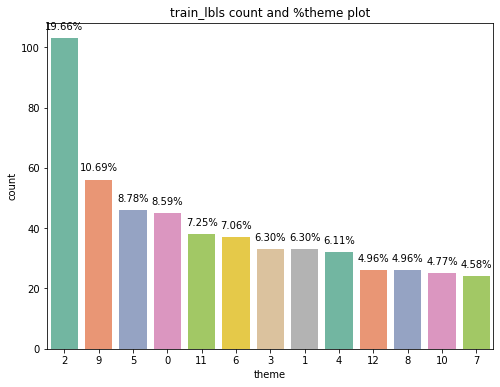

In [ ]:
plot_count(df=train_lbls_df, feature='theme', title = 'train_lbls count and %theme plot')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


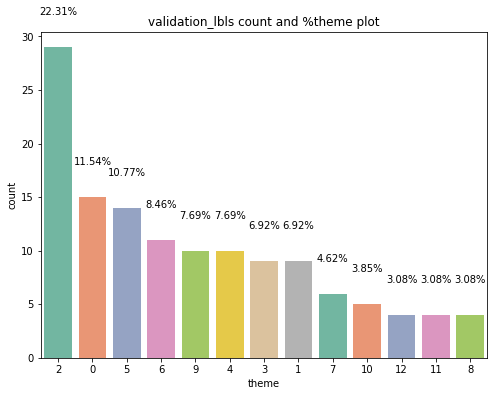

In [ ]:
plot_count(df=validation_lbls_df, feature='theme', title = 'validation_lbls count and %theme plot')

### 前処理
* 数値データをfloat32へ
* データを0〜255を0〜１へ
* labelデータ退避
* （labelを0〜12からonehot表現へ）

In [ ]:
class Preprocessor(object):
    def transform(self, imgs, lbls=None):
        imgs = self._convert_imgs_dtypes(imgs)
        imgs = self._normalize(imgs)
        if lbls is None:
            return imgs
        lbls = self._to_categorical_labels(lbls)
        return imgs, lbls

    def _convert_imgs_dtypes(self, imgs):
        _imgs = imgs.astype('float32')
        return _imgs

    def _normalize(self, imgs):
        # _imgs = (imgs - 128.0) / 128.0
        _imgs = imgs / 255.0
        return _imgs

    def _to_categorical_labels(self, lbls):
        label_num = len(np.unique(lbls))
        _lbls = to_categorical(lbls, label_num)
        return _lbls

In [ ]:
def to_categorical_labels(lbls, label_num):
    lbls = to_categorical(lbls, label_num)
    return lbls

In [ ]:
def draw(X):
    """描画を行う関数
    """
    fig = plt.figure(figsize=(15, 50))
    for i in range(X.shape[0]):
        ax = fig.add_subplot(20, 5, i+1)
        ax.tick_params(labelbottom=False, bottom=False)
        ax.tick_params(labelleft=False, left=False)
        img = X[i]
        ax.imshow(img.reshape(224,224,3), cmap='gray')
    fig.show()

In [ ]:
# データの正規化（画像データ）
train_imgs = Preprocessor().transform(train_imgs)
validation_imgs = Preprocessor().transform(validation_imgs)

# labelデータ退避
train_lbls_save = train_lbls.copy()
validation_lbls_save = validation_lbls.copy()

In [ ]:
# Efficientnet b0
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [ ]:
# 学習済み重みは固定
feature_extractor_layer.trainable = False

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
def model_create(feature_extractor_layer):
    # モデルの生成
    model = Sequential()

    # EfficientnetB0
    model.add(feature_extractor_layer)

    # Flatten層
    model.add(Flatten())

    # 全結合層
    model.add(Dense(700, activation='relu'))
    model.add(Dropout(0.35))
    # 全結合層
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    # 全結合層
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.45))

    # 全結合層
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.55))
        
    # 出力層
    model.add(Dense(2, activation='softmax'))

    # モデルをコンパイル
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['acc'])
    
    return model

In [ ]:
def model_fit(train_imgs, train_lbls, validation_imgs, validation_lbls):
    epochs = 10
    steps_per_epoch = None

    batch_stats_callback = CollectBatchStats()

    history = model.fit(train_imgs, train_lbls, epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=(validation_imgs, validation_lbls),
                        verbose=0,
                        callbacks = [batch_stats_callback])
    
    predict_lbls = model.predict(validation_imgs, batch_size=64)

    return history, predict_lbls

In [ ]:
def model_test_fit(test_imgs,train_imgs,train_lbls):
    epochs = 10
    steps_per_epoch = None

    batch_stats_callback = CollectBatchStats()

    history = model.fit(train_imgs, train_lbls, epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        verbose=0,
                        callbacks = [batch_stats_callback])
    
    predict_lbls = model.predict(test_imgs, batch_size=64)

    return predict_lbls

In [ ]:
def theme_judg(df, label_array, theme):
    df['S'] = df.sum(axis=1)
    for i in range(len(df)):
        label_array[i][theme] = df.iloc[i]['S']
    return label_array

In [ ]:
majority_num = 4
theme_num = 3
label_array = np.zeros([len(validation_lbls), theme_num]) - 1
model = model_create(feature_extractor_layer)

for k in range(majority_num):
    label_majority = np.zeros([len(validation_lbls), majority_num])
    for theme in range(theme_num):
        print('theme: ', theme)
        # テーマ毎に０−１ラベルにする
        train_lbls_bina = np.where(train_lbls_save == theme, 1, 0)
        validation_lbls_bina = np.where(validation_lbls_save == theme, 1, 0)

        train_lbls = to_categorical_labels(train_lbls_bina, 2)
        validation_lbls = to_categorical_labels(validation_lbls_bina, 2)

        # 定めたテーマ毎に学習
        for i in range(10):
            predict_lbls = model_fit(train_imgs, train_lbls, validation_imgs, validation_lbls)
            if i == 0:
                df = pd.DataFrame(np.argmax(predict_lbls[1], axis=1), columns=['y'])
            else:
                df_tmp = pd.DataFrame(np.argmax(predict_lbls[1], axis=1), columns=['y'])
                df = pd.concat([df, df_tmp], axis=1)
        label_array = theme_judg(df, label_array, theme)
    if k == 0:
        df_majority = pd.DataFrame(np.argmax(label_array, axis=1), columns=[k])
    else:
        df_tmp = pd.DataFrame(np.argmax(label_array, axis=1), columns=[k])
        df_majority = pd.concat([df_majority, df_tmp], axis=1)

df_majority['W'] = df_majority.mode(axis=1)
majority_area = np.zeros([2, theme_num])
majority_percent_list = list(np.zeros(theme_num))
for j in range(len(validation_lbls_save)):
    majority_area[0][validation_lbls_save[j]] += 1
    majority_area[1][df_majority.iloc[j]['W']] += 1
for j in range(theme_num):
    majority_percent_list[j] = majority_area[1][j] / majority_area[0][j]

df = pd.DataFrame(np.argmax(label_array, axis=1), columns=['y'])
df.to_csv("/content/drive/MyDrive/Probdata/test24.csv")
# np.save('/content/drive/MyDrive/Probdata/validation_imgs', validation_imgs)
np.save('/content/drive/MyDrive/Probdata/validation_lbls_save', validation_lbls_save)

In [ ]:
df_majority.mode(axis=1)

,0,1
0,2.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN
...,...,...
125,2.0,NaN
126,0.0,NaN
127,0.0,NaN
128,2.0,NaN


In [ ]:
df_majority[['W','F']] = df_majority.mode(axis=1)
majority_area = np.zeros([2, theme_num])
majority_percent_list = list(np.zeros(theme_num))
for j in range(len(validation_lbls_save)):
    majority_area[0][int(validation_lbls_save[j])] += 1
    majority_area[1][df_majority.iloc[j]['W']] += 1
for j in range(theme_num):
    majority_percent_list[j] = majority_area[1][j] / majority_area[0][j]

In [ ]:
int(validation_lbls_save[7])

5

In [ ]:
validation_lbls_df = pd.DataFrame(validation_lbls_save)
validation_lbls_df.to_csv('/content/drive/MyDrive/Probdata/validation_lbls_df.csv')

In [ ]:
df = pd.DataFrame(np.argmax(label_array, axis=1), columns=['y'])
df_lbls = pd.DataFrame(validation_lbls_save, columns=['y'])
df = pd.concat([df, df_lbls], axis=1)
ans_list = []
for i in range(len(df)):
    if df.loc[i][0] == df.loc[i][1]:
        ans_list.append(1)
    else:
        ans_list.append(0)

df['S'] = ans_list
print('AAAA', df['S'].sum()/len(df))